In [2]:
%matplotlib inline

In [21]:
import os
import json
import shutil
from typing import List, Dict, Any, Iterable, Optional, Tuple
import random

import torch
from torch import nn
from torch.utils.data import DataLoader, IterableDataset

import pyarrow as pa
import pyarrow.parquet as pq

import numpy as np
import awkward as ak

import itertools
import pandas as pd
import matplotlib.pyplot as plt


# ====== USER CONFIG ======
EOS_BASE = "/eos/project/f/foundational-model-dataset/samples/production_final"
EOS_TARGET ="/eos/user/p/phploner/foundation_model_testing_data"
AFS_TMPDIR = "/eos/user/p/phploner/foundation_model_testing_data/tmpdir"

#SELECTED_6 = {
#    "DY": "DY to ll",
#    "QCD": "QCD inclusive",
#    "SingleHiggs": "VBFHtautau",
#    "top": "tt all-lept",
#    "diboson": "WZ (semi-leptonic)",
#    "diHiggs": "HH bbtautau",
#}


# Feature packing hyperparams
K_PART = 20   # top-K PUPPI particles by pT
K_JET  = 4    # top-J AK4 jets by pT

# Training config
EVENTS_PER_CLASS = 500000
TRAIN_VAL_RATIO = 0.95
BATCH_SIZE      = 1024
EPOCHS          = 10
LR              = 2e-3
SEED            = 42
SAVE_LABEL      = "classifier_test"
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
random.seed(SEED)
torch.manual_seed(SEED)


Using device: cpu


In [5]:
# SPECIFY HERE WHICH COLUMNS OF THE DATASET TO TAKE FOR THE TRAINING
# The columns are given in groups (e.g. particles, jets etc.)
# cols: are the specific columns to be read
# topk: are the amount of objects to be taken from the columns, they are sorted in descending order w.r.t. the first col
# e.g. "particles": {
#       "cols": [
#           "FullReco_PUPPIPart_PT",
#           "FullReco_PUPPIPart_Eta",
#           "FullReco_PUPPIPart_Phi",
#       ]
#       "topk": 20,
# takes the 20 particles with the highest PT (first col) and sorts them from highest to lowest
# topk = 1 means only the highest object w.r.t the first column is taken
# topk = None is used for scalar values where no ordering/selecting needs to be done (e.g. MET)
# count: is a bool that specifies if an additional column should be made with the total number of objects (e.g. # of particles)
            
            
DATASETS_CONFIG = {
    "particles": {
        "cols": [
            "FullReco_PUPPIPart_PT",
            "FullReco_PUPPIPart_Eta",
            "FullReco_PUPPIPart_Phi",
            "FullReco_PUPPIPart_Charge",
            "FullReco_PUPPIPart_Mass",
            "FullReco_PUPPIPart_PID",
            "FullReco_PUPPIPart_PuppiW",
        ],
        "topk": K_PART,
        "count": True,
    },
    "jets": {
        "cols": [
            "FullReco_JetAK4_PT",
            "FullReco_JetAK4_Eta",
            "FullReco_JetAK4_Phi",
            "FullReco_JetAK4_Mass",
            "FullReco_JetAK4_BTag",
            "FullReco_JetAK4_Charge",
        ],
        "topk": K_JET,
        "count": True,
    },
    "electrons": {
        "cols": [
            "FullReco_Electron_PT",
            "FullReco_Electron_Eta",
            "FullReco_Electron_Phi",
            "FullReco_Electron_EhadOverEem",
            "FullReco_Electron_IsolationVarRhoCorr",
        ],
        "topk": 1,
        "count": False,
    },
    "muons": {
        "cols": [
            "FullReco_MuonTight_PT",
            "FullReco_MuonTight_Eta",
            "FullReco_MuonTight_Phi",
            "FullReco_MuonTight_IsolationVarRhoCorr",
        ],
        "topk": 1,
        "count": False,
    },
    "photons": {
        "cols": [
            "FullReco_PhotonTight_PT",
            "FullReco_PhotonTight_Eta",
            "FullReco_PhotonTight_Phi",
        ],
        "topk": 1,
        "count": False,
    },
    "primary_vertex": {
        "cols": [
            "FullReco_PrimaryVertex_SumPT2",
            "FullReco_PrimaryVertex_Z",
        ],
        "topk": 1,
        "count": False,
    },
    "met": {
        "cols": [
            "FullReco_PUPPIMET_MET",
            "FullReco_PUPPIMET_Phi",
            "FullReco_MET_MET",
            "FullReco_MET_Phi",
        ],
        "topk": None,  # special scalar
        "count": False,
    },
}


# SPECIFY HERE WHICH PROCESSES TO USE FOR THE CLASSIFIER TRAINING
# The keys are labels used in the training
# The values are the exact process names as in the list below

# These are the possible processes:

# "DY to ll"
# "Z to vv + jet"
# "Z to qq (uds)"
# "Z to bb"
# "Z to cc"
# "W to lv"
# "W to qq"
# "gamma"
# "gamma + V"
# "tri-gamma"
#    
# "QCD inclusive"
# "QCD bb"
# "Minbias / Soft QCD"
#    
# "tt all-hadr"
# "tt semi-lept"
# "tt all-lept"
# "ttH incl"
# "tttt"
# "ttW incl"
# "ttZ incl"
#    
# "WW all-leptonic"
# "WW all-hadronic"
# "WW semi-leptonic"
# "WZ all-leptonic"
# "WZ all-hadronic"
# "WZ semi-leptonic"
# "ZZ all-leptonic"
# "ZZ all-hadronic"
# "ZZ semi-leptonic"
# "VVV"
# "VH incl"
#    
# "ggHbb"
# "ggHcc"
# "ggHgammagamma"
# "ggHgluglu"
# "ggHtautau"
# "ggHWW"
# "ggHZZ"
# "VBFHbb"
# "VBFHcc"
# "VBFHgammagamma"
# "VBFHgluglu"
# "VBFHtautau"
# "VBFHWW"
# "VBFHZZ"
#    
# "HH 4b"
# "HH bbtautau"
# "HH bbWW"
# "HH bbZZ"
# "HH bbgammagamma"

TO_CLASSIFY = {
    "QCD": "QCD inclusive",
    "ggHbb": "ggHbb",
}


In [6]:
# Pretty name -> folder name (from your mapping)
PROCESS_TO_FOLDER = {
    # DY / Z / W
    "DY to ll": "DYJetsToLL_13TeV-madgraphMLM-pythia8",
    "Z to vv + jet": "ZJetsTovv_13TeV-madgraphMLM-pythia8",
    "Z to qq (uds)": "ZJetsToQQ_13TeV-madgraphMLM-pythia8",
    "Z to bb": "ZJetsTobb_13TeV-madgraphMLM-pythia8",
    "Z to cc": "ZJetsTocc_13TeV-madgraphMLM-pythia8",
    "W to lv": "WJetsToLNu_13TeV-madgraphMLM-pythia8",
    "W to qq": "WJetsToQQ_13TeV-madgraphMLM-pythia8",
    "gamma": "gamma",
    "gamma + V": "gamma_V",
    "tri-gamma": "tri_gamma",

    # QCD
    "QCD inclusive": "QCD_HT50toInf",
    "QCD bb": "QCD_HT50tobb",
    "Minbias / Soft QCD": "minbias",

    # top
    "tt all-hadr": "tt0123j_5f_ckm_LO_MLM_hadronic",
    "tt semi-lept": "tt0123j_5f_ckm_LO_MLM_semiLeptonic",
    "tt all-lept": "tt0123j_5f_ckm_LO_MLM_leptonic",
    "ttH incl": "ttH_incl",
    "tttt": "tttt_incl",
    "ttW incl": "ttW_incl",
    "ttZ incl": "ttZ_incl",

    # dibosons
    "WW all-leptonic": "WW_leptonic",
    "WW all-hadronic": "WW_hadronic",
    "WW semi-leptonic": "WW_semileptonic",
    "WZ all-leptonic": "WZ_leptonic",
    "WZ all-hadronic": "WZ_hadronic",
    "WZ semi-leptonic": "WZ_semileptonic",
    "ZZ all-leptonic": "ZZ_leptonic",
    "ZZ all-hadronic": "ZZ_hadronic",
    "ZZ semi-leptonic": "ZZ_semileptonic",
    "VVV": "VVV_incl",
    "VH incl": "VH_incl",

    # single-Higgs
    "ggHbb": "ggHbb",
    "ggHcc": "ggHcc",
    "ggHgammagamma": "ggHgammagamma",
    "ggHgluglu": "ggHgluglu",
    "ggHtautau": "ggHtautau",
    "ggHWW": "ggHWW",
    "ggHZZ": "ggHZZ",
    "VBFHbb": "VBFHbb",
    "VBFHcc": "VBFHcc",
    "VBFHgammagamma": "VBFHgammagamma",
    "VBFHgluglu": "VBFHgluglu",
    "VBFHtautau": "VBFHtautau",
    "VBFHWW": "VBFHWW",
    "VBFHZZ": "VBFHZZ",

    # di-Higgs
    "HH 4b": "HH_4b",
    "HH bbtautau": "HH_bbtautau",
    "HH bbWW": "HH_bbWW",
    "HH bbZZ": "HH_bbZZ",
    "HH bbgammagamma": "HH_bbgammagamma",
}

CLASS_NAMES = list(TO_CLASSIFY.keys())
PRETTY = {c: TO_CLASSIFY[c] for c in CLASS_NAMES}
FOLDER = {c: PROCESS_TO_FOLDER[PRETTY[c]] for c in CLASS_NAMES}
LABELS = {c: i for i, c in enumerate(CLASS_NAMES)}
print("Classes:", CLASS_NAMES)
print("Pretty per class:", PRETTY)
print("Folder per class:", FOLDER)


Classes: ['QCD', 'ggHbb']
Pretty per class: {'QCD': 'QCD inclusive', 'ggHbb': 'ggHbb'}
Folder per class: {'QCD': 'QCD_HT50toInf', 'ggHbb': 'ggHbb'}


In [7]:
def get_all_cols(config=DATASETS_CONFIG):
    cols = []
    for spec in config.values():
        cols.extend(spec["cols"])
    return cols


def compute_vlen(config=DATASETS_CONFIG):
    total = 0
    for spec in config.values():
        ncols = len(spec["cols"])
        topk = spec["topk"]
        if topk is None:  # scalars
            total += ncols
        else:
            total += ncols * topk
        if spec.get("count", False):
            total += 1
    return total


ALL_COLS = get_all_cols(DATASETS_CONFIG)
VLEN = compute_vlen(DATASETS_CONFIG)
print("The length of the feature vector is " + str(VLEN))

The length of the feature vector is 184


In [8]:
def _pack_topk_batch(pt, *others, k: int, fill: float):
    """
    Picks top k pt (or whatever is put in the first argument) particles/jets/vertices with pt and others as features.
    This is vectorized: pt and others are ak.Arrays of shape (n_events, var).
    Returns: np.ndarray of shape (n_events, k, n_features)
    """
    # stack features → shape (n_events, n_objects, n_features)
    arrays = (pt,) + others
    expanded = [arr[:, :, None] for arr in arrays]
    stacked = ak.concatenate(expanded, axis=2)
    
    # argsort by pt descending (feature 0)
    stacked = ak.values_astype(stacked, np.float32)
    stacked = stacked[ak.argsort(stacked[:, :, 0], axis=1, ascending=False)]
    
    # take top-k
    topk = stacked[:, :k, :]
    n_features = len(arrays)
    
    # pad to length k (for events with <k objects) and fill with n_features*[fill]
    topk = ak.pad_none(topk, k, axis=1)
    fill_list = n_features*[fill]
    topk = ak.fill_none(topk, fill_list, axis=1)
    
    # transform to regular numpy array
    topk_np = ak.to_numpy(topk)
    
    return topk_np

def _pack_leading_batch(pt, *others, fill: float):
    """
    Picks top 1 pt (or whatever is put in the first argument) particles/jets/vertices with pt and others as features.
    This is vectorized: pt and others are ak.Arrays of shape (n_events, var).
    Returns: np.ndarray of shape (n_events, 1, n_features)
    """
    # stack features → shape (n_events, n_objects, n_features)
    arrays = (pt,) + others
    expanded = [arr[:, :, None] for arr in arrays]
    stacked = ak.concatenate(expanded, axis=2)
    
    # argmax by max pt (feature 0)
    stacked = ak.values_astype(stacked, np.float32)
    leading = stacked[ak.argmax(stacked[:, :, 0], axis=1, keepdims=True)]
    n_features = len(arrays)
    
    # pad to length 1 (for events with <1 objects) and fill with n_features*[fill]
    leading = ak.pad_none(leading, 1, axis=1)
    fill_list = n_features*[fill]
    leading = ak.fill_none(leading, fill_list, axis=1)
    
    # transform to regular numpy array
    leading_np = ak.to_numpy(leading)
    
    return leading_np

def build_vectors_batch(batch, config=DATASETS_CONFIG, fill=0.0):
    """
    batch: dict mapping column name to the corresponding awkward array
    config: DATASETS_CONFIG dict
    fill: float fill value everywhere it needs to be padded

    Returns: np.ndarray of shape (n_events, VLEN)
    """
    features = []

    for name, spec in config.items():
        cols = spec["cols"]
        topk = spec["topk"]

        if topk is None:
            # --- scalars (e.g. MET) ---
            vals = [ak.to_numpy(ak.fill_none(batch[c], fill)).reshape(-1, 1) for c in cols]
            group = np.concatenate(vals, axis=1)  # (n_events, ncols)

        elif topk == 1:
            # --- leading object ---
            arrays = [batch[c] for c in cols]
            group = _pack_leading_batch(*arrays, fill=fill)
            group = group.reshape(len(group), -1)

        else:
            # --- top-k objects ---
            arrays = [batch[c] for c in cols]
            group = _pack_topk_batch(*arrays, k=topk, fill=fill)
            group = group.reshape(len(group), -1)

        features.append(group)

        # --- optional count feature ---
        if spec.get("count", False):
            nobj = ak.num(batch[cols[0]], axis=1).to_numpy().reshape(-1,1)
            features.append(nobj)

    # concatenate everything → final feature vector
    out = np.concatenate(features, axis=1)
    return out  # shape (n_events, VLEN)



In [9]:
def save_feature_map(config: dict, out_dir: str, vlen: int):
    """Save a single feature_map.json describing your flattened vector layout."""
    feature_map = {}
    offset = 0

    for group_name, cfg in config.items():
        cols = cfg["cols"]
        topk = cfg["topk"]
        count = cfg.get("count", False)

        if topk is None:
            size = len(cols)
        else:
            size = topk * len(cols)
            if count:
                size += 1

        feature_map[group_name] = {
            "start": int(offset),
            "end": int(offset + size),
            "columns": cols,
            "topk": topk,
            "count": count,
        }
        offset += size

    os.makedirs(out_dir, exist_ok=True)
    with open(os.path.join(out_dir, "feature_map.json"), "w") as f:
        json.dump(feature_map, f, indent=2)
    print(f"✓ feature_map.json saved → {out_dir}")


In [10]:
class EOSDataset(IterableDataset):
    def __init__(self, base_dir, seed=42, per_class_limit=None, batch_size=512):
        """
        base_dir: EOS root dir with all class folders
        seed: random seed
        per_class_limit: max number of events per class (optional)
        batch_size: how many rows to pull from parquet at once
        """
        self.base_dir = base_dir
        self.seed = seed
        self.per_class_limit = per_class_limit
        self.batch_size = batch_size

    def __iter__(self):
        # Step 1: collect parquet files for all classes
        all_files = []
        for cname in CLASS_NAMES:
            folder = os.path.join(self.base_dir, FOLDER[cname])
            files = [
                os.path.join(folder, f)
                for f in os.listdir(folder)
                if f.endswith(".parquet") and not f.startswith(".")
            ]
            for f in files:
                all_files.append((cname, f))

        # Step 2: shuffle file order
        rng = random.Random(self.seed)
        rng.shuffle(all_files)

        # Step 3: iterate over files
        counters = {c: 0 for c in CLASS_NAMES}
        for cname, path in all_files:
            if self.per_class_limit and counters[cname] >= self.per_class_limit:
                continue
            with pq.ParquetFile(path) as pqf:
                for batch in pqf.iter_batches(columns=ALL_COLS, batch_size=self.batch_size):
                    # convert arrow batch → awkward
                    tbl = pa.Table.from_batches([batch])
                    arrays = {col: ak.from_arrow(tbl[col]) for col in ALL_COLS}
                    # vectorize into np.ndarray (N, VLEN)
                    feats = build_vectors_batch(arrays, DATASETS_CONFIG)
                    n = feats.shape[0]

                    # enforce per-class limit
                    if self.per_class_limit:
                        remain = self.per_class_limit - counters[cname]
                        if remain <= 0:
                            break
                        feats = feats[:remain]
                        n = feats.shape[0]

                    counters[cname] += n
                    labels = np.full((n,), LABELS[cname], dtype=np.int64)

                    yield {"x": feats, "y": labels}

                    if self.per_class_limit and counters[cname] >= self.per_class_limit:
                        break

                    
class ShuffleBuffer(torch.utils.data.IterableDataset):
    def __init__(self, dataset, buffer_size=10000, seed=42):
        """
        buffer_size: how many whole batches to buffer
        """
        super().__init__()
        self.dataset = dataset
        self.buffer_size = buffer_size
        self.rng = random.Random(seed)

    def __iter__(self):
        buf = []
        for batch in self.dataset:
            buf.append(batch)
            if len(buf) >= self.buffer_size:
                idx = self.rng.randrange(len(buf))
                yield buf.pop(idx)
        while buf:
            idx = self.rng.randrange(len(buf))
            yield buf.pop(idx)

            



In [11]:
def move_to_eos(local_dir, eos_dir):
    os.makedirs(os.path.dirname(eos_dir), exist_ok=True)
    print(f"→ Moving {local_dir} → {eos_dir}")
    shutil.move(local_dir, eos_dir)
    print(f"✅ Moved to {eos_dir}")

def vectorized_to_local(base_dir, config, out_dir, split_ratio=0.8, per_class_limit=None, batch_size=512):
    """Stream from EOS, vectorize, and save each Parquet shard as a .npy pair."""
    os.makedirs(out_dir, exist_ok=True)
    save_feature_map(config, out_dir, VLEN)

    for cname in CLASS_NAMES:
        folder = os.path.join(base_dir, FOLDER[cname])
        files = sorted(f for f in os.listdir(folder) if f.endswith(".parquet") and not f.startswith("."))
        counters = 0

        for f in files:
            if per_class_limit and counters >= per_class_limit:
                break
            path = os.path.join(folder, f)
            print(f"→ Processing {path}")

            all_feats, all_labels = [], []
            with pq.ParquetFile(path) as pqf:
                for batch in pqf.iter_batches(columns=ALL_COLS, batch_size=batch_size):
                    tbl = pa.Table.from_batches([batch])
                    arrays = {col: ak.from_arrow(tbl[col]) for col in ALL_COLS}
                    feats = build_vectors_batch(arrays, config, fill=0.0)
                    n = feats.shape[0]

                    if per_class_limit:
                        remain = per_class_limit - counters
                        feats = feats[:remain]
                        n = feats.shape[0]

                    all_feats.append(feats)
                    all_labels.append(np.full((n,), LABELS[cname], dtype=np.int64))
                    counters += n

                    if per_class_limit and counters >= per_class_limit:
                        break

            if not all_feats:
                continue

            feats_cat = np.concatenate(all_feats, axis=0)
            labels_cat = np.concatenate(all_labels, axis=0)
            
            split = "train" if counters <= split_ratio*per_class_limit else "val"
            temp_save_dir = os.path.join(AFS_TMPDIR, SAVE_LABEL, "vectorized", split, FOLDER[cname])
            save_dir = os.path.join(EOS_TARGET, SAVE_LABEL, "vectorized", split, FOLDER[cname])
            os.makedirs(temp_save_dir, exist_ok=True)
            
            base = os.path.splitext(f)[0]
            local_x_file = os.path.join(temp_save_dir, f"{base}_x.npy")
            local_y_file = os.path.join(temp_save_dir, f"{base}_y.npy")
            np.save(local_x_file, feats_cat)
            np.save(local_y_file, labels_cat)
            shutil.move(local_x_file, os.path.join(save_dir, local_x_file))
            shutil.move(local_y_file, os.path.join(save_dir, local_y_file))
            
            print(f"  ✓ Saved {base}: {feats_cat.shape}")

    print(f"✅ Finished vectorizing → {out_dir}")


In [12]:
AFS_VEC_OUT = os.path.join(AFS_TMPDIR, SAVE_LABEL, "vectorized")
EOS_VEC_OUT   = os.path.join(EOS_TARGET, SAVE_LABEL, "vectorized")
AFS_PREPROC_OUT = os.path.join(AFS_TMPDIR, "vectorized_preprocessed")
EOS_PREPROC_OUT = os.path.join(EOS_TARGET, "vectorized_preprocessed")

In [13]:
# --- Stage 1: vectorize to local AFS scratch ---
vectorized_to_local(EOS_BASE, DATASETS_CONFIG, AFS_VEC_OUT, split_ratio=TRAIN_VAL_RATIO, per_class_limit=EVENTS_PER_CLASS, batch_size=512)

# --- Stage 2: move to EOS ---
move_to_eos(AFS_VEC_OUT, EOS_VEC_OUT)


✓ feature_map.json saved → /eos/user/p/phploner/foundation_model_testing_data/tmpdir/classifier_test/vectorized
→ Processing /eos/project/f/foundational-model-dataset/samples/production_final/QCD_HT50toInf/QCD_HT50toInf-NEVENT10000-RS26000001.parquet


KeyboardInterrupt: 

In [14]:
class LocalVectorDataset(torch.utils.data.IterableDataset):
    def __init__(self, base_dir, seed=42, per_class_limit=None):
        super().__init__()
        self.base_dir = base_dir  # path to vectorized/
        self.seed = seed
        self.per_class_limit = per_class_limit

    def __iter__(self):
        class_dirs = [
            os.path.join(self.base_dir, folder)
            for folder in os.listdir(self.base_dir)
            if os.path.isdir(os.path.join(self.base_dir, folder))
        ]

        rng = random.Random(self.seed)
        rng.shuffle(class_dirs)

        counters = {}
        for class_dir in class_dirs:
            cname = os.path.basename(class_dir)
            files_x = sorted(
                f for f in os.listdir(class_dir)
                if f.endswith("_x.npy")
            )
            rng.shuffle(files_x)
            counters[cname] = 0

            for fx in files_x:
                fy = fx.replace("_x.npy", "_y.npy")
                X = np.load(os.path.join(class_dir, fx))
                y = np.load(os.path.join(class_dir, fy))

                if self.per_class_limit:
                    remain = self.per_class_limit - counters[cname]
                    if remain <= 0:
                        break
                    X = X[:remain]
                    y = y[:remain]
                    counters[cname] += len(y)
                else:
                    counters[cname] += len(y)

                yield {"x": X, "y": y}


In [ ]:
val_stream = LocalVectorDataset(
    os.path.join(EOS_TARGET, SAVE_LABEL, "vectorized", "val"),
    seed=SEED + 1000
)

Xv, Yv = [], []
for batch in val_stream:
    Xv.append(batch["x"])
    Yv.append(batch["y"])

X_val = torch.tensor(np.concatenate(Xv, axis=0), dtype=torch.float32)
y_val = torch.tensor(np.concatenate(Yv, axis=0), dtype=torch.long)
print("Val set:", X_val.shape, y_val.shape)


Val set: torch.Size([57984, 184]) torch.Size([57984])


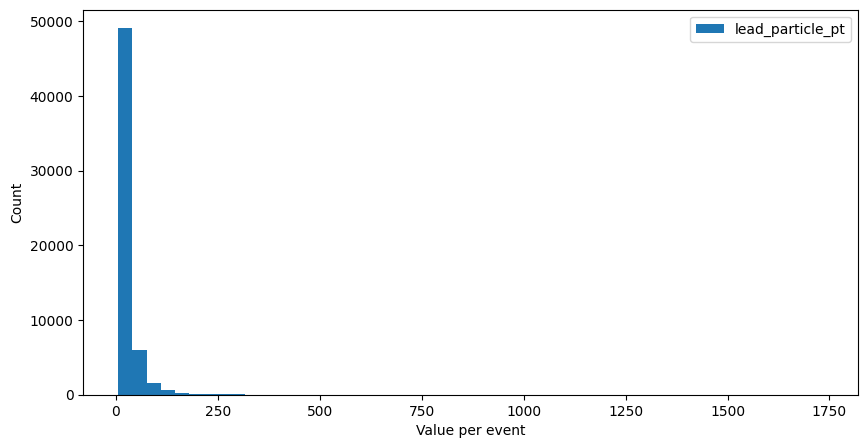

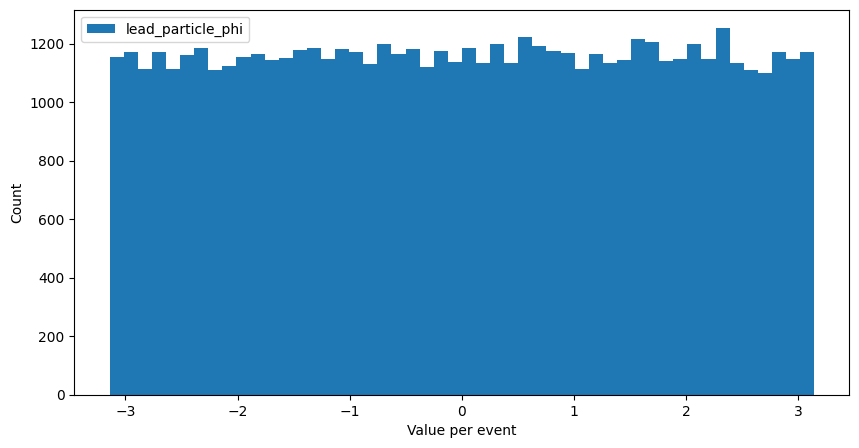

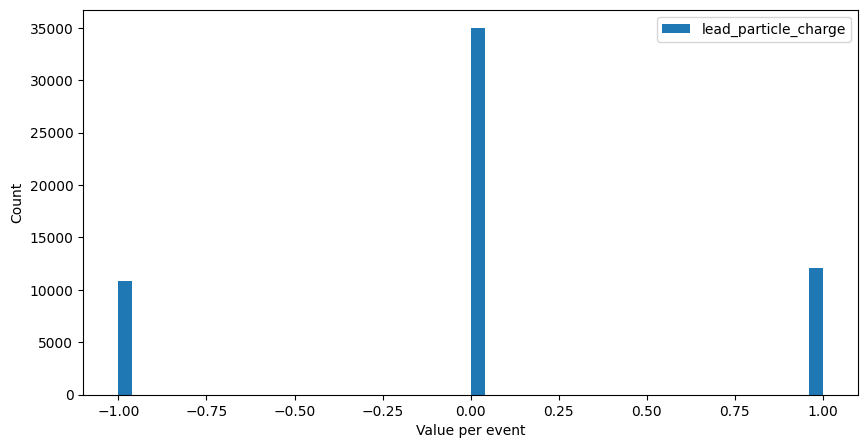

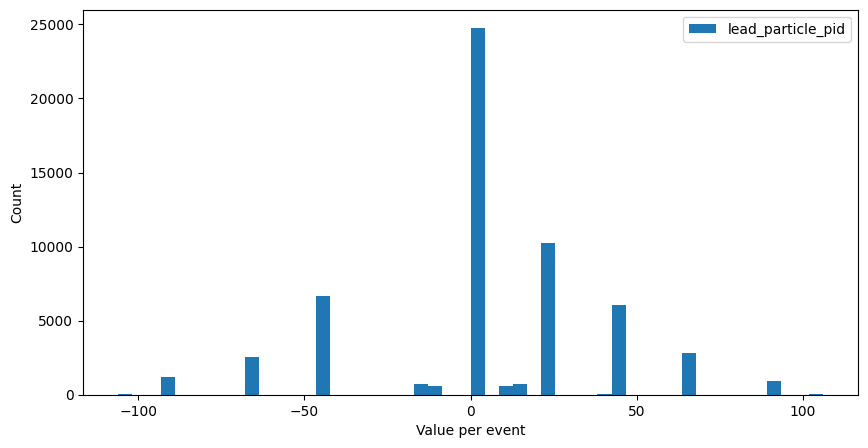

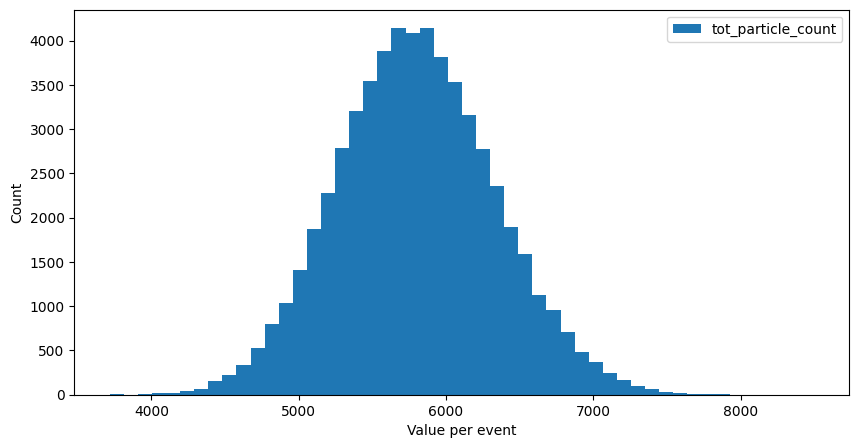

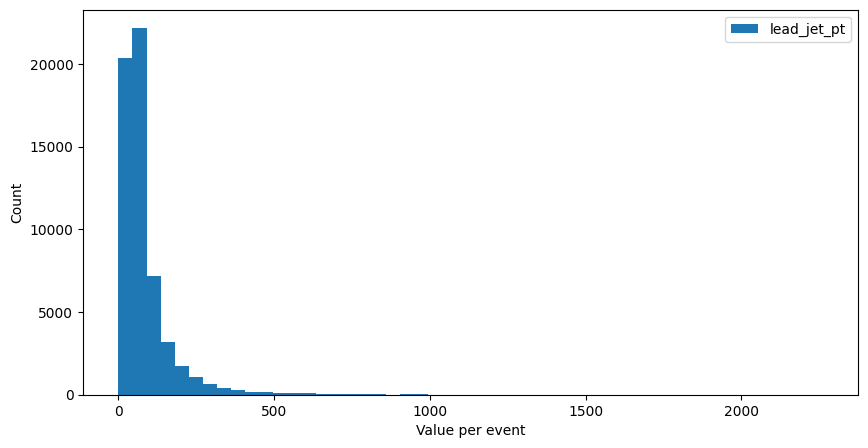

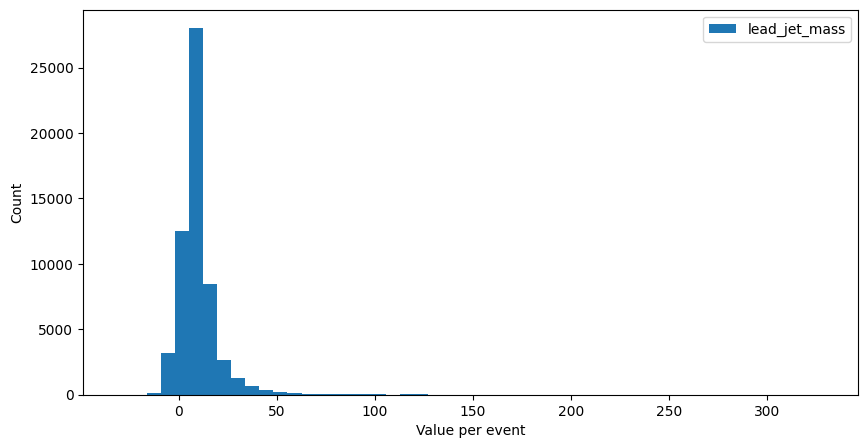

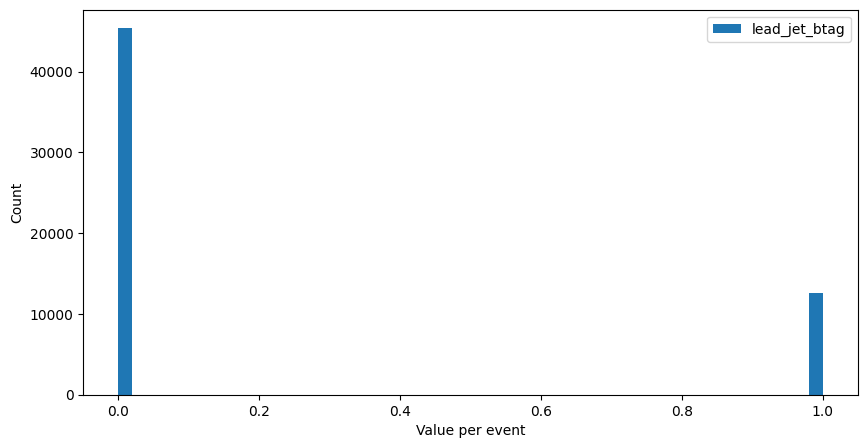

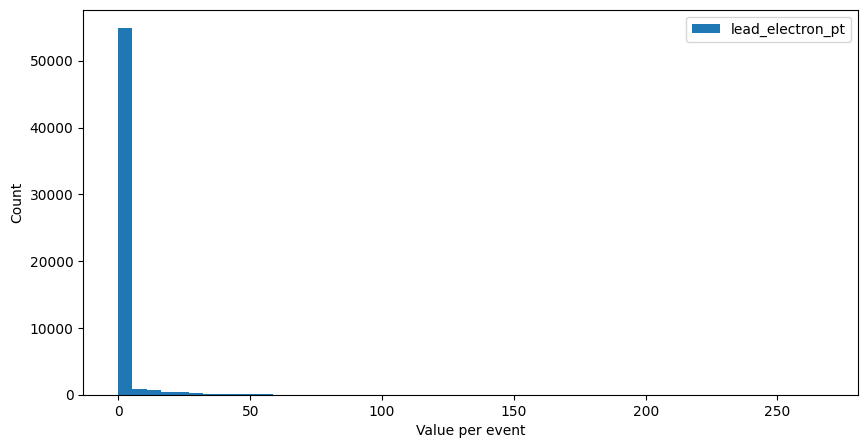

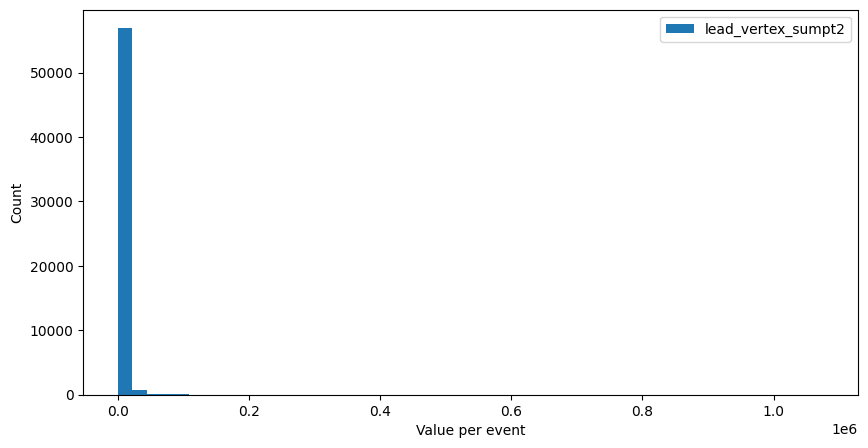

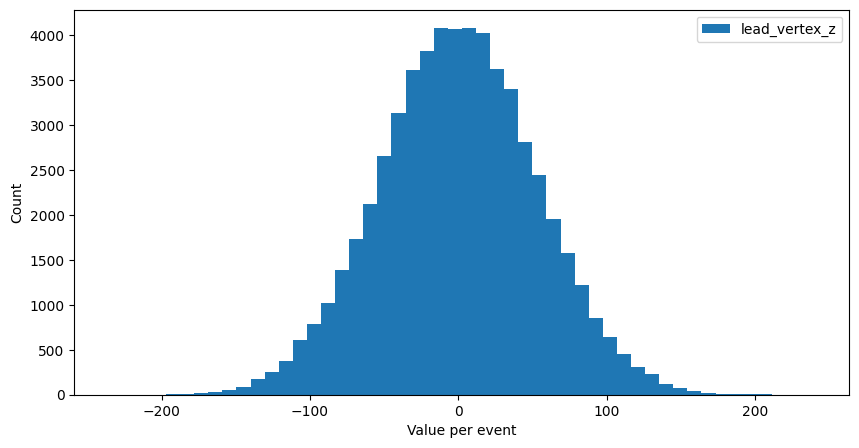

In [16]:
to_plot=[0,2,3,5,140,141,144,145,166,178,179]
legends=["lead_particle_pt","lead_particle_phi","lead_particle_charge","lead_particle_pid","tot_particle_count","lead_jet_pt","lead_jet_mass","lead_jet_btag","lead_electron_pt","lead_vertex_sumpt2","lead_vertex_z"]
for i,legend in zip(to_plot,legends):
    plt.figure(figsize=(10,5))
    plt.hist(X_val[:,i], bins=50, label=legend)
    plt.xlabel("Value per event")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

In [17]:
def estimate_mean_std(vectorized_dir, per_class_limit=None):
    count = 0
    mean = None
    M2 = None

    ds = LocalVectorDataset(vectorized_dir, seed=SEED + 222, per_class_limit=per_class_limit)

    for batch in ds:
        xb = torch.tensor(batch["x"], dtype=torch.float32)
        for x in xb:
            if mean is None:
                mean = torch.zeros_like(x)
                M2 = torch.zeros_like(x)
            count += 1
            delta = x - mean
            mean += delta / count
            delta2 = x - mean
            M2 += delta * delta2

    var = M2 / max(count - 1, 1)
    std = torch.sqrt(var + 1e-6)
    return mean, std


MEAN, STD = estimate_mean_std(os.path.join(EOS_TARGET, SAVE_LABEL, "vectorized", "train"), per_class_limit=10000)
print("Mean:", MEAN[:10])
print("Std:", STD[:10])


Mean: tensor([2.8178e+01, 3.0402e-02, 1.6945e-03, 1.1000e-02, 1.1241e-01, 3.4336e+00,
        6.0281e-01, 1.9194e+01, 3.0395e-02, 2.4143e-03])
Std: tensor([31.9174,  2.3702,  1.8094,  0.6282,  0.2171, 34.9113,  0.4710, 17.7646,
         2.4716,  1.8132])


In [18]:
# Materialize validation set once
Xv, Yv = [], []
for batch in val_stream:   
    xb = torch.tensor(batch["x"], dtype=torch.float32)
    yb = torch.tensor(batch["y"], dtype=torch.long)
    # normalize here
    xb = (xb - MEAN) / STD
    Xv.append(xb)
    Yv.append(yb)

# concatenate along batch dimension
X_val = torch.cat(Xv, dim=0)
y_val = torch.cat(Yv, dim=0)

print("Val set:", X_val.shape, y_val.shape)

Val set: torch.Size([57984, 184]) torch.Size([57984])


In [19]:
class TinyMLP(nn.Module):
    def __init__(self, num_classes, d=VLEN, h=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, h), nn.ReLU(),
            nn.Linear(h, h//2), nn.ReLU(),
            nn.Linear(h//2, num_classes),
        )
    def forward(self, x):
        return self.net(x)

model = TinyMLP(num_classes=len(CLASS_NAMES), d=VLEN, h=256).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [22]:
def evaluate(model, X, y, batch=512):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i in range(0, len(X), batch):
            xb = X[i:i+batch].to(DEVICE)
            yb = y[i:i+batch].to(DEVICE)
            logits = model(xb)
            pred = logits.argmax(dim=1)
            correct += int((pred == yb).sum().item())
            total += int(len(yb))
    model.train()
    return correct / max(total, 1)

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch {epoch}")

    train_stream = LocalVectorDataset(
        os.path.join(EOS_TARGET, SAVE_LABEL, "vectorized", "train"),
        seed=SEED + epoch,
    )

    shuffled_train = ShuffleBuffer(train_stream, buffer_size=10000, seed=SEED + epoch)
    train_loader = DataLoader(shuffled_train, batch_size=None, num_workers=0)

    running_loss = 0.0

    for step, batch in enumerate(train_loader, start=1):
        x = batch["x"].to(dtype=torch.float32, device=DEVICE)
        y = batch["y"].to(dtype=torch.long, device=DEVICE)

        x = (x - MEAN) / STD

        logits = model(x)
        loss = loss_fn(logits, y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        running_loss += loss.item()
        if step % 20 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss {running_loss / 20:.4f}")
            running_loss = 0.0

    acc = evaluate(model, X_val, y_val)
    print(f"[Epoch {epoch}] Validation accuracy: {acc * 100:.2f}% | Classes: {CLASS_NAMES}")

print("Training finished.")


Starting epoch 1
Epoch 1 | Step 20 | Loss 0.3172
Epoch 1 | Step 40 | Loss 0.4314
Epoch 1 | Step 60 | Loss 0.4016
Epoch 1 | Step 80 | Loss 0.3653
Epoch 1 | Step 100 | Loss 0.3854
[Epoch 1] Validation accuracy: 85.56% | Classes: ['QCD', 'ggHbb']
Starting epoch 2
Epoch 2 | Step 20 | Loss 0.3948
Epoch 2 | Step 40 | Loss 0.3785
Epoch 2 | Step 60 | Loss 0.3816
Epoch 2 | Step 80 | Loss 0.4082
Epoch 2 | Step 100 | Loss 0.3720
[Epoch 2] Validation accuracy: 84.92% | Classes: ['QCD', 'ggHbb']
Starting epoch 3
Epoch 3 | Step 20 | Loss 0.2760
Epoch 3 | Step 40 | Loss 0.3766
Epoch 3 | Step 60 | Loss 0.4033
Epoch 3 | Step 80 | Loss 0.3614
Epoch 3 | Step 100 | Loss 0.4095
[Epoch 3] Validation accuracy: 85.31% | Classes: ['QCD', 'ggHbb']
Starting epoch 4
Epoch 4 | Step 20 | Loss 0.3793
Epoch 4 | Step 40 | Loss 0.3265
Epoch 4 | Step 60 | Loss 0.4102
Epoch 4 | Step 80 | Loss 0.3707
Epoch 4 | Step 100 | Loss 0.3690
[Epoch 4] Validation accuracy: 85.53% | Classes: ['QCD', 'ggHbb']
Starting epoch 5
Epoch 5